# Konbriefing.
El archivo CSV contiene un registro de ciberataques dirigidos a diferentes industrias y sectores en múltiples países.

## Importación de librerías.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import json
from urllib.parse import urlparse
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## Visualización de los datos.

In [2]:
df = pd.read_csv('../data/KONBRIEFING.csv')
df.head()

,date,title,description,references,date_uploaded
0,April 2024,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",2024-04-29
1,"April 25, 2024",Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",2024-04-29
2,"April 25, 2024",Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...","[{""title"":""Notre ville est actuellement victim...",2024-04-29
3,"April 25, 2024",Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...","[{""title"":""KC Scout Alert"",""url"":""https://www....",2024-04-29
4,"April 24, 2024",Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium","[{""title"":""Stadsdiensten van Deinze geplaagd d...",2024-04-29


In [3]:
df.describe()

,date,title,description,references,date_uploaded
count,67310,67326,67358,67358,67358
unique,1129,4027,4030,4053,16
top,"May 31, 2023",Cyber attack on a university of applied scienc...,? - USA,[],2024-04-29
freq,6624,218,1296,2803,4392


In [4]:
df.shape

(67358, 5)

In [5]:
df.dtypes

date             object
title            object
description      object
references       object
date_uploaded    object
dtype: object

In [6]:
df.columns

Index(['date', 'title', 'description', 'references', 'date_uploaded'], dtype='object')

El archivo contiene 67,358 registros  y tiene las siguientes columnas:

- **Date**: Fecha del ataque (aunque algunos valores están incompletos).
- **Title**: Título del incidente.
- **Description**: Descripción del incidente, que puede incluir la víctima o el sector.
- **References**: Fuentes de referencia para el incidente.
- **Date Uploaded**: Fecha de subida del incidente al sistema.

## Limpieza de los datos.
En un análisis de ciberseguridad, las columnas más importantes son **date** (fecha del ataque), **title** (título del incidente) y **description** (descripción del ataque), ya que proporcionan la información necesaria para identificar patrones temporales, tipos de ataques y sectores afectados. Estas son fundamentales para estudios sobre tendencias, como el aumento de incidentes en ciertos periodos o vulnerabilidades en sectores específicos. Por otro lado, las columnas **date_uploaded** y **references** son menos relevantes para el análisis de patrones, ya que solo indican cuándo se documentó el incidente y las fuentes, aunque pueden ser útiles para validar la información.

In [7]:
df.drop(columns=['date_uploaded'], inplace=True)
df.head(2)

,date,title,description,references
0,April 2024,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der..."
1,"April 25, 2024",Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur..."


In [8]:
def extract_title_url(reference_column):
    titles, urls = [], []

    for ref in reference_column:
        if not ref:
            titles.append("")
            urls.append("")
            continue

        try:

            ref_json = json.loads(ref)


            if isinstance(ref_json, list) and len(ref_json) > 0:
                first_ref = ref_json[0]


                title = first_ref.get("title", "")
                url = first_ref.get("url", "")


                site_name = urlparse(url).netloc.replace('www.', '') if url else ""

                titles.append(title)
                urls.append(site_name)
            else:
                titles.append("")
                urls.append("")
        except (json.JSONDecodeError, IndexError, TypeError) as e:

            titles.append("")
            urls.append("")

    return titles, urls

df['title_extracted'], df['site_name_extracted'] = extract_title_url(df['references'])

df.head(10)



,date,title,description,references,title_extracted,site_name_extracted
0,April 2024,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria","[{""title"":""Hackerangriff auf Facebookseite der...",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at
1,"April 25, 2024",Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...","[{""title"":""Cyberangriff auf Max Wild GmbH"",""ur...",Cyberangriff auf Max Wild GmbH,maxwild.com
2,"April 25, 2024",Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...","[{""title"":""Notre ville est actuellement victim...",Notre ville est actuellement victime d’une cyb...,facebook.com
3,"April 25, 2024",Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...","[{""title"":""KC Scout Alert"",""url"":""https://www....",KC Scout Alert,facebook.com
4,"April 24, 2024",Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium","[{""title"":""Stadsdiensten van Deinze geplaagd d...",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be
5,April 2024,A municipality in Argentina loses 19 million p...,"San Agustín, Provincia de Santa Fe, Argentina","[{""title"":""LA COMUNA DE SAN AGUSTÍN VÍCTIMA DE...",LA COMUNA DE SAN AGUSTÍN VÍCTIMA DE DELITO CIB...,facebook.com
6,"April 23, 2024",Cyber attack on a municipality in Canada,"Municipalité La Guadeloupe - La Guadeloupe, Qu...","[{""title"":""Le 23 avril dernier, la Municipalit...","Le 23 avril dernier, la Municipalité de La Gua...",facebook.com
7,"April 23, 2024",Website of a Czech news agency hacked,České noviny (ČN) / Česká tisková kancelář (ČT...,"[{""title"":""UPOZORNĚNÍ ČTK: Útočník napadl web ...",UPOZORNĚNÍ ČTK: Útočník napadl web České novin...,ctk.cz
8,April 2024,"Cyber attack on a logistics company in Sweden,...",Skanlog - Sweden,"[{""title"":""Hackerangrep kan gi tomme hyller ho...",Hackerangrep kan gi tomme hyller hos Systembol...,e24.no
9,"April 22, 2024",Cyber attack on a city government in France,"Ville d'Albi - Albi, Occitanie, France","[{""title"":""La Ville d'Albi victime d'une attaq...",La Ville d'Albi victime d'une attaque informat...,mairie-albi.fr


In [9]:
df.shape

(67358, 6)

In [10]:
df.drop(columns=['references'], inplace=True)
df.head(2)

,date,title,description,title_extracted,site_name_extracted
0,April 2024,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at
1,"April 25, 2024",Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com


In [11]:
# Función para limpiar la fecha
def limpiar_fecha(fecha):
    # Eliminar caracteres no deseados
    fecha = re.sub(r'[?]', '', fecha)  # Eliminar signos de interrogación
    fecha = fecha.strip()  # Eliminar espacios al inicio y al final
    return fecha

# Función para procesar la fecha
def procesar_fecha(fecha):
    # Limpiar la cadena de fecha
    fecha = limpiar_fecha(fecha)

    # Si la fecha está vacía después de limpiar
    if not fecha:
        return pd.NaT

    # Verificar los formatos de fecha y convertir directamente 'date'
    if re.match(r'^\d{1,2}\. \w+ \d{4}$', fecha):
        # Formato: DÍA. MES AÑO
        return pd.to_datetime(fecha, format='%d. %B %Y', errors='coerce')
    elif re.match(r'^\w+/\w+ \d{4}$', fecha):
        # Formato: MES/MES AÑO
        meses = fecha.split('/')
        return pd.to_datetime(f"{meses[0]} 1 {meses[1]}", format='%B 1 %Y', errors='coerce')
    elif re.match(r'^\w+ \d{1,2}, \d{4}$', fecha):
        # Formato: MES DÍA, AÑO
        return pd.to_datetime(fecha, format='%B %d, %Y', errors='coerce')
    elif re.match(r'^\w+ \d{4}$', fecha):
        # Formato: MES AÑO
        return pd.to_datetime(fecha, format='%B %Y', errors='coerce')
    elif re.match(r'^\d{1,2} \w+ \d{4}$', fecha):
        # Formato: DÍA MES, AÑO
        return pd.to_datetime(fecha, format='%d %B %Y', errors='coerce')
    elif re.match(r'^\d{1,2} \w+$', fecha):
        # Formato: DÍA MES (sin año)
        return pd.to_datetime(fecha + ' 2000', format='%d %B %Y', errors='coerce')
    else:
        return pd.NaT

# Asegurarse de que la columna 'date' sea de tipo string
df['date'] = df['date'].astype(str)

# Aplicar la función procesar_fecha directamente sobre 'date'
df['date'] = df['date'].apply(procesar_fecha)

# Obtener mes y día a partir de 'date'
mes_dia = df['date'].apply(lambda x: (x.month, x.day) if pd.notnull(x) else (None, None))

# Crear DataFrame con los resultados
df_resultado = pd.DataFrame(mes_dia.tolist(), columns=['Mes', 'Día'])

# Añadir la columna 'date' original procesada
df_resultado['date'] = df['date']

# Mostrar resultados
print(df_resultado)



        Mes   Día       date
0       4.0   1.0 2024-04-01
1       4.0  25.0 2024-04-25
2       4.0  25.0 2024-04-25
3       4.0  25.0 2024-04-25
4       4.0  24.0 2024-04-24
...     ...   ...        ...
67353  12.0  28.0 2021-12-28
67354  12.0  28.0 2021-12-28
67355  12.0   1.0 2021-12-01
67356  12.0  29.0 2021-12-29
67357  12.0  31.0 2021-12-31

[67358 rows x 3 columns]


In [12]:

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['year'] = df['date'].dt.year.astype('Int64')
df['month'] = df['date'].dt.month.astype('Int64')



df.head(2)

,date,title,description,title_extracted,site_name_extracted,year,month
0,2024-04-01,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4
1,2024-04-25,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4


### Tratamiento de filas nulas.
EL dataframe inicial contiene 67000 filas. Se ha observado que las columas **date** tenia valores nulos en 48 filas, y **title** en 32 filas. Lo que representa menos del 1% de filas en los dos casos, por lo que se considera lo más apropiado eliminarlas.

In [13]:
df.isnull().sum()

date                   990
title                   32
description              0
title_extracted          0
site_name_extracted      0
year                   990
month                  990
dtype: int64

In [14]:
for i in ['title','date']:
    df = df.dropna(subset=[i])

In [15]:
df.isnull().sum()

date                   0
title                  0
description            0
title_extracted        0
site_name_extracted    0
year                   0
month                  0
dtype: int64

In [16]:
df.drop(columns=['date'], inplace=True)

In [17]:
nulos_title_extracted = df['title_extracted'].isnull().sum()
nulos_site_name_extracted = df['site_name_extracted'].isnull().sum()

vacios_title_extracted = (df['title_extracted'] == '').sum()
vacios_site_name_extracted = (df['site_name_extracted'] == '').sum()

print(f"Valores nulos en 'title_extracted': {nulos_title_extracted}")
print(f"Valores vacíos en 'title_extracted': {vacios_title_extracted}")
print(f"Valores nulos en 'site_name_extracted': {nulos_site_name_extracted}")
print(f"Valores vacíos en 'site_name_extracted': {vacios_site_name_extracted}")


Valores nulos en 'title_extracted': 0
Valores vacíos en 'title_extracted': 2771
Valores nulos en 'site_name_extracted': 0
Valores vacíos en 'site_name_extracted': 2883


In [18]:
df = df[(df['title_extracted'].notnull()) & (df['title_extracted'] != '') &
                (df['site_name_extracted'].notnull()) & (df['site_name_extracted'] != '')]

df.head()


,title,description,title_extracted,site_name_extracted,year,month
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4
2,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...",Notre ville est actuellement victime d’une cyb...,facebook.com,2024,4
3,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...",KC Scout Alert,facebook.com,2024,4
4,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be,2024,4


In [19]:
df.isnull().sum()

title                  0
description            0
title_extracted        0
site_name_extracted    0
year                   0
month                  0
dtype: int64

In [20]:
df = df.dropna(subset=['year', 'month'])

month_year = pd.to_datetime(
    df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2),
    format='%Y-%m'
).dt.to_period('M')

attacks_per_month = month_year.value_counts().sort_index()

print(attacks_per_month)

print(df.head(2))



2014-04      16
2021-01     432
2021-02     544
2021-03     736
2021-04     688
2021-05     640
2021-06     800
2021-07    1152
2021-08    1264
2021-09    1216
2021-10    1552
2021-11    1136
2021-12    1632
2022-01    1776
2022-02    1952
2022-03    2336
2022-04    2448
2022-05    2272
2022-06    1600
2022-07    1104
2022-08    1584
2022-09    1552
2022-10    1808
2022-11    1536
2022-12    2032
2023-01    2031
2023-02    2052
2023-03    2416
2023-04    2336
2023-05    6538
2023-06    1536
2023-07    1241
2023-08    1487
2023-09    1632
2023-10    2090
2023-11    2022
2023-12    1339
2024-01    1334
2024-02     978
2024-03     460
2024-04     153
Freq: M, dtype: int64
                                               title  \
0  Facebook page of the local branch of a politic...   
1  Cyber attack on a construction company in Germany   

                                         description  \
0   SPÖ Müllendorf - Müllendorf, Burgenland, Austria   
1  Max Wild GmbH - Berkheim, Baden-Württe

In [21]:
df.shape

(63453, 6)

### Tratamiento de filas duplicadas.


In [22]:
df.shape

(63453, 6)

In [23]:

duplicados_antes = df.duplicated().sum()
print(f"Filas duplicadas antes de eliminar: {duplicados_antes}")


df_cleaned = df.drop_duplicates(keep=False)


duplicados_despues = df_cleaned.duplicated().sum()
print(f"Filas duplicadas después de eliminar: {duplicados_despues}")


Filas duplicadas antes de eliminar: 59303
Filas duplicadas después de eliminar: 0


## Análisis de los datos por tiempo

Para este dataframe esinteresante hacer un análisis temporal para ver las tendencias de los incidentes a lo largo del tiempo.

El análisis temporal de los incidentes muestra que el registro más antiguo corresponde a octubre de 2010, y luego hay un salto hasta abril de 2014. A partir de enero de 2021, el número de incidentes coienza a umentar significativamiente. HAcemos una gráfica para observar mejor estos datos.

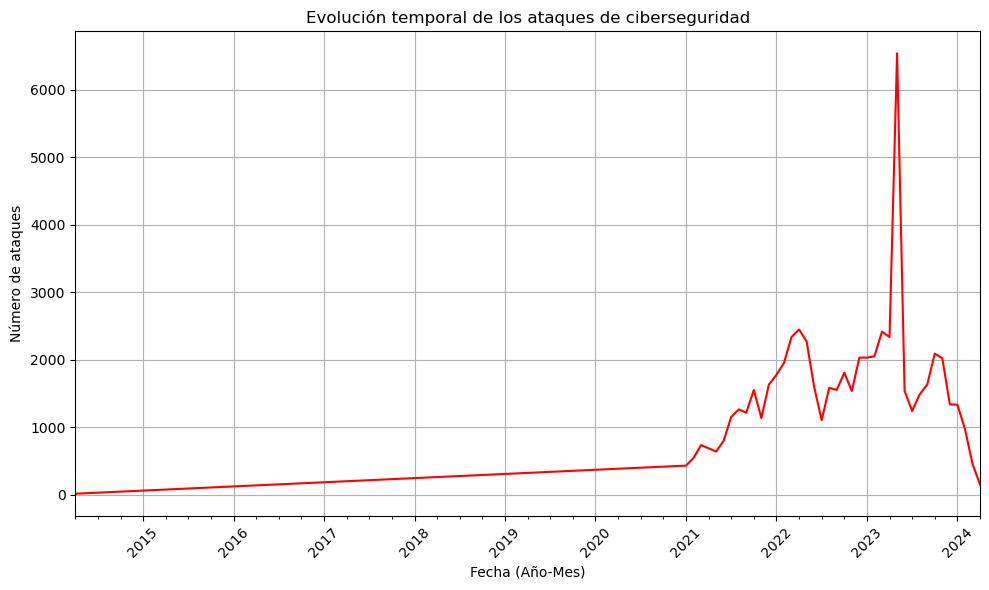

In [24]:

month_year = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str).str.zfill(2), format='%Y-%m').dt.to_period('M')

temporal_analysis = month_year.value_counts().sort_index()


plt.figure(figsize=(10, 6))
temporal_analysis.plot(kind='line', color='red')
plt.title('Evolución temporal de los ataques de ciberseguridad')
plt.xlabel('Fecha (Año-Mes)')
plt.ylabel('Número de ataques')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


El gráfico muestra un aumento significativo en los ataques de ciberseguridad a partir de 2021, con picos en varios meses. Esto puede estar relacionado con el incremento de incidentes a nivel mundial debido a la pandemia y ala mayor digitalización.

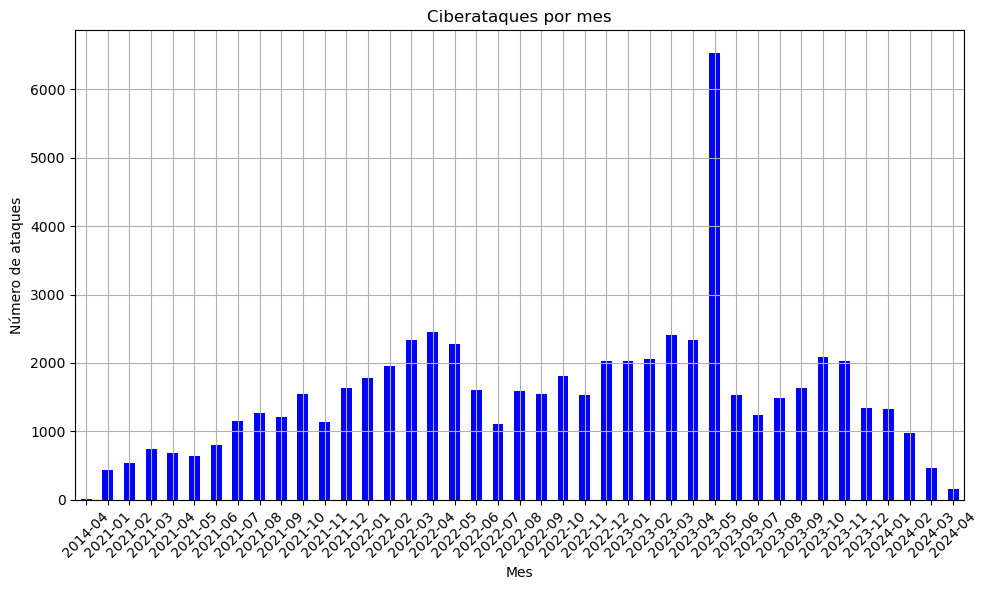

In [25]:
attacks_per_month.sort_index().plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Ciberataques por mes')
plt.xlabel('Mes')
plt.ylabel('Número de ataques')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Se observa claramente que en abril de 2023 hubo un alto número de ataques.

## Análisis por sectores

In [26]:

sectors = {
    'Gobierno y servicios públicos': [
        'government', 'public administration', 'municipality', 'city',
        'federal', 'state', 'local', 'public sector', 'regulatory agency', 'department',
        'agency', 'bureau', 'authority'
    ],
    'Salud y cuidado': [
        'health', 'healthcare', 'hospital', 'medical', 'pharmaceutical',
        'biotechnology', 'telehealth', 'nursing', 'clinic', 'doctor',
        'medical facility', 'health insurance', 'dentistry', 'wellness'
    ],
    'Educación': [
        'education', 'university', 'college', 'school', 'academic',
        'institute', 'training', 'vocational', 'tuition', 'online learning',
        'educational institution', 'scholarship'
    ],
    'Finanzas y banca': [
        'bank', 'financial', 'fintech', 'insurance', 'investment',
        'venture capital', 'mortgage', 'credit', 'loans', 'stock market',
        'payment processing', 'currency exchange', 'brokerage', 'savings',
        'credit union'
    ],
    'Tecnología y telecomunicaciones': [
        'technology', 'tech', 'it', 'software', 'hardware', 'cloud computing',
        'internet service provider', 'network provider', 'cybersecurity',
        'data protection', 'privacy', 'AI', 'artificial intelligence',
        'machine learning', 'data analytics', 'mobile', 'telecom',
        'app development', 'e-commerce'
    ],
    'Energía y recursos': [
        'energy', 'oil', 'gas', 'power', 'utilities', 'renewable',
        'solar', 'wind', 'nuclear', 'electricity', 'water supply',
        'waste management', 'agriculture', 'farming', 'biofuels',
        'natural resources'
    ],
    'Construcción e infraestructura': [
        'construction', 'infrastructure', 'engineering', 'real estate development',
        'architecture', 'contractor', 'landscaping', 'building materials',
        'civil engineering', 'urban planning'
    ],
    'Transporte y logística': [
        'transport', 'logistics', 'shipping', 'aerospace', 'automotive',
        'airline', 'hospitality', 'travel', 'tourism', 'supply chain',
        'public transport', 'freight', 'cargo', 'distribution',
        'shipping lines', 'delivery services'
    ],
    'Comercio y servicios': [
        'retail', 'e-commerce', 'wholesale', 'consumer goods',
        'online services', 'home services', 'cleaning', 'maintenance',
        'repair', 'restaurant', 'food and beverage', 'grocery', 'apparel',
        'fashion', 'shopping'
    ],
    'Industria y manufactura': [
        'manufacturing', 'production', 'industry', 'factory',
        'food processing', 'textiles', 'automotive manufacturing',
        'pharmaceutical manufacturing', 'chemical manufacturing',
        'construction materials', 'consumer electronics', 'heavy machinery'
    ],
    'Medios y entretenimiento': [
        'media', 'news', 'journalism', 'entertainment', 'broadcasting',
        'art', 'culture', 'sports', 'fitness', 'health and wellness',
        'social media', 'music', 'film', 'television', 'streaming',
        'gaming', 'theater'
    ],
    'Sector militar y defensa': [
        'military', 'defense', 'army', 'navy', 'air force',
        'intelligence', 'national security', 'defense contractor',
        'weapons', 'cyber defense', 'surveillance', 'homeland security'
    ],
    'Organizaciones sin fines de lucro': [
        'non-profit', 'ngo', 'charity', 'philanthropy',
        'foundations', 'advocacy', 'community service',
        'human rights', 'environmental', 'social justice',
        'international organization'
    ],
    'Servicios profesionales': [
        'legal', 'law firm', 'consulting', 'professional services',
        'accounting', 'auditing', 'management', 'marketing',
        'human resources', 'public relations', 'real estate',
        'investment advisory', 'financial consulting'
    ],
    'Sector de investigación y desarrollo': [
        'research', 'development', 'laboratory', 'science',
        'technology transfer', 'innovation', 'R&D',
        'clinical trials', 'academic research', 'scientific research'
    ],
    'Agricultura y alimentación': [
        'agriculture', 'farming', 'food production',
        'agrochemical', 'livestock', 'dairy',
        'fishing', 'food distribution', 'organic',
        'farm-to-table'
    ],
    'Sector medioambiental': [
        'environment', 'ecology', 'sustainability',
        'wildlife', 'conservation', 'pollution',
        'recycling', 'climate change', 'renewable energy',
        'green technology'
    ],
}

In [27]:

def extract_sector(text):
    for group, keywords in sectors.items():
        for sector in keywords:
            if re.search(sector, text, re.IGNORECASE):
                return group
    return 'other'


df['sector'] = df['description'].apply(extract_sector)


sector_analysis = df['sector'].value_counts()

other_sectors = sector_analysis[sector_analysis.index == 'other']

print("Número de incidentes clasificados como 'other':")
print(other_sectors)


unclassified_count = df[df['sector'] == 'other'].shape[0]
print(f"Total de incidentes clasificados como 'other': {unclassified_count}")

print("\nAnálisis de sectores agrupados:")
print(sector_analysis)


Número de incidentes clasificados como 'other':
other    30442
Name: sector, dtype: int64
Total de incidentes clasificados como 'other': 30442

Análisis de sectores agrupados:
other                                   30442
Tecnología y telecomunicaciones         16957
Educación                                4624
Gobierno y servicios públicos            4071
Salud y cuidado                          3635
Finanzas y banca                         1449
Medios y entretenimiento                 1090
Energía y recursos                        413
Transporte y logística                    237
Servicios profesionales                   148
Sector de investigación y desarrollo      130
Organizaciones sin fines de lucro          65
Construcción e infraestructura             48
Industria y manufactura                    48
Sector militar y defensa                   48
Comercio y servicios                       48
Name: sector, dtype: int64


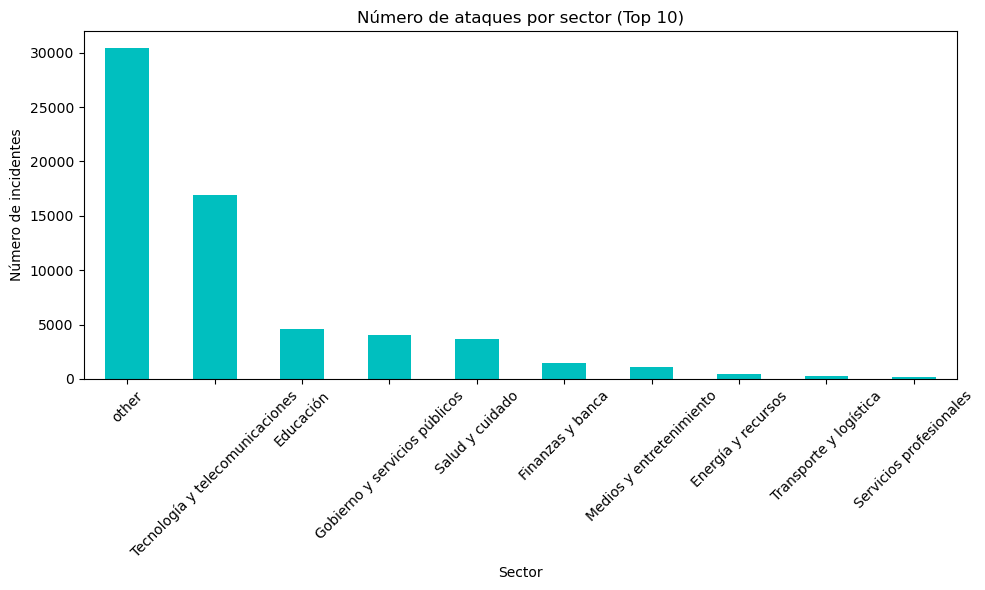

In [28]:
top_10_sectors = sector_analysis.nlargest(10)


plt.figure(figsize=(10, 6))
top_10_sectors.plot(kind='bar', color='c')

plt.title('Número de ataques por sector (Top 10)')
plt.xlabel('Sector')
plt.ylabel('Número de incidentes')


plt.xticks(ticks=range(len(top_10_sectors)), labels=top_10_sectors.index, rotation=45)

plt.tight_layout()
plt.show()

## Análisis de ataques por país

In [29]:
df['country'] = df['description'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

attacks_per_country = df['country'].value_counts()

print(attacks_per_country)

Germany                                                              5971
France                                                               4438
USA                                                                  4168
United Kingdom                                                       2775
Canada                                                               2571
                                                                     ... 
USA (Coffee County)                                                     1
Coppel - Mexico                                                         1
Germany (Landkreis Unterallgäu)                                         1
Skanlog - Sweden                                                        1
České noviny (ČN) / Česká tisková kancelář (ČTK) - Czech Republik       1
Name: country, Length: 888, dtype: int64


In [30]:
def clean_country_name(country):
  if '-' in country:
    cleaned_name = country.split('-')[-1].strip()
  else:
    cleaned_name = re.sub(r"\(.*?\)", "", country).strip()
  return cleaned_name.strip()

  df['country_clean'] = df['country'].apply(clean_country_name)
  df.head(10)

In [31]:


  continents_mapping = {

    'Africa': [
        'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic',
        'Chad', 'Comoros', 'Congo', 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon',
        'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Ivory Coast', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar',
        'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
        'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
        'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe', 'Libya / ليبيا'
    ],
    'Asia': [
        'Afghanistan', 'Armenia', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'Cyprus',
        'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan',
        'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'North Korea', 'Oman', 'Pakistan',
        'Palestine', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan',
        'Tajikistan', 'Thailand', 'Timor-Leste', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen',
        "People's Republic of China", 'Republic of China / Taiwan', 'Jordanien / الأردن', 'Malediven / ދިވެހިރާއްޖޭގެ ޖުމްހޫރިއްޔާ'
    ],
    'Europe': [
        'Albania', 'Andorra', 'Austria', 'Azerbaijan', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria',
        'Croatia', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany', 'Greece',
        'Hungary', 'Iceland', 'Ireland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta',
        'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
        'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom',
        'Vatican City', 'Czech Republik', 'Upper Austria', 'Kingdom of the Netherlands', 'Serbien / Србија', 'UK', 'Isle of Man',
        'Vatican'
    ],
    'North America': [
        'Antigua and Barbuda', 'Bahamas', 'Barbados', 'Belize', 'Canada', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic',
        'El Salvador', 'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama',
        'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States of America (USA)',
        'USA', 'Grönland', 'Puerto Rico', 'Bermuda', 'United States of America'
    ],
    'South America': [
        'Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'
    ],
    'Oceania': [
        'Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea',
        'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu'
    ]
}




In [32]:
def assign_continent(country_clean):
  continents = set()

  for continent, countries_list in continents_mapping.items():
    if country_clean in countries_list:
       continents.add(continent)
  return ', '.join(continents) if continents else 'Sin continente'

df['country_clean'] = df['country'].apply(clean_country_name)
df['continent'] = df['country_clean'].apply(assign_continent)

sin_continente_rows = df[df['continent'] == 'Sin continente']
print(sin_continente_rows)

print(f"Número de filas sin continente: {len(sin_continente_rows)}")


                                                   title  \
3      Cyber attack on a traffic management system in...   
36     Unauthorized access at a telecommunications pr...   
71     Ransomware at a county government in Missouri,...   
78     Cyber attack on a school district in Michigan,...   
85              Cyber attack on a hotel chain in the USA   
...                                                  ...   
67204  Unauthorized access at a benefit plan service ...   
67241  Cyber attack with emails on global furniture s...   
67267  Hackers capture $200 million from the BitMart ...   
67286   Cyberattack on a healthcare provider in Guernsey   
67304  140 million US dollars stolen from crypto plat...   

                                             description  \
3      KC Scout - Kansas City, Missouri, USA (Jackson...   
36     Frontier Communications - Dallas, Texas, USA (...   
71     Jackson County - Kansas City, Missouri, USA (J...   
78     Traverse City Area Public School

In [33]:
df.head(10)

,title,description,title_extracted,site_name_extracted,year,month,sector,country,country_clean,continent
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4,other,Austria,Austria,Europe
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4,other,Germany (Landkreis Biberach),Germany,Europe
2,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...",Notre ville est actuellement victime d’une cyb...,facebook.com,2024,4,other,France,France,Europe
3,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...",KC Scout Alert,facebook.com,2024,4,Gobierno y servicios públicos,Platte County),Platte County),Sin continente
4,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be,2024,4,other,Belgium,Belgium,Europe
5,A municipality in Argentina loses 19 million p...,"San Agustín, Provincia de Santa Fe, Argentina",LA COMUNA DE SAN AGUSTÍN VÍCTIMA DE DELITO CIB...,facebook.com,2024,4,other,Argentina,Argentina,South America
6,Cyber attack on a municipality in Canada,"Municipalité La Guadeloupe - La Guadeloupe, Qu...","Le 23 avril dernier, la Municipalité de La Gua...",facebook.com,2024,4,Tecnología y telecomunicaciones,Canada,Canada,North America
7,Website of a Czech news agency hacked,České noviny (ČN) / Česká tisková kancelář (ČT...,UPOZORNĚNÍ ČTK: Útočník napadl web České novin...,ctk.cz,2024,4,other,České noviny (ČN) / Česká tisková kancelář (ČT...,Czech Republik,Europe
8,"Cyber attack on a logistics company in Sweden,...",Skanlog - Sweden,Hackerangrep kan gi tomme hyller hos Systembol...,e24.no,2024,4,other,Skanlog - Sweden,Sweden,Europe
9,Cyber attack on a city government in France,"Ville d'Albi - Albi, Occitanie, France",La Ville d'Albi victime d'une attaque informat...,mairie-albi.fr,2024,4,Tecnología y telecomunicaciones,France,France,Europe


In [34]:
df = df.drop(columns=['country', 'country_clean'])

## Análisis de tipo de ciberataque

In [35]:
attack_types = {
    'ransomware': [
        'ransomware', 'encrypt', 'extortion', 'locker', 'crypto', 'bitcoin', 'cryptolocker', 'decrypt',
        'payment demanded', 'file encryption', 'ransom', 'data hostage', 'crypto-ransom', 'hostage data',
        'ransomed files', 'malware ransom', 'blackmail'
    ],
    'phishing': [
        'phishing', 'email scam', 'spear-phishing', 'fraud', 'social engineering', 'fake email', 'whaling',
        'vishing', 'smishing', 'email impersonation', 'credential harvesting', 'account hijack',
        'spoofed email', 'phishing attempt', 'phish', 'deceptive emails', 'phishing link',
        'malicious attachment', 'fake login page'
    ],
    'ddos': [
        'ddos', 'denial of service', 'dos', 'botnet', 'traffic flood', 'amplification', 'overload',
        'slow loris', 'ping of death', 'udp flood', 'syn flood', 'reflection attack', 'service outage',
        'distributed denial of service', 'traffic spike', 'botnet traffic', 'service disruption',
        'volumetric attack', 'application layer attack', 'protocol attack'
    ],
    'malware': [
        'malware', 'virus', 'trojan', 'worm', 'spyware', 'adware', 'exploit', 'keylogger', 'rootkit', 'backdoor',
        'malicious software', 'malware infection', 'payload', 'malicious code', 'remote access trojan',
        'fileless malware', 'infostealer', 'stealer malware', 'rogueware', 'wiper', 'PUP', 'potentially unwanted program',
        'packers', 'downloaders'
    ],
    'intrusion': [
        'intrusion', 'breach', 'unauthorized access', 'compromise', 'penetration', 'hack', 'infiltration',
        'access control bypass', 'security breach', 'system intrusion', 'data breach', 'system compromise',
        'network intrusion', 'unauthorized entry', 'hacking attempt', 'attack vector', 'unauthorized modification',
        'internal attack'
    ],
    'spoofing': [
        'spoofing', 'impersonation', 'fake', 'fraudulent', 'falsification', 'identity theft', 'caller id spoofing',
        'email spoofing', 'ip spoofing', 'domain spoofing', 'website spoofing', 'fake profile',
        'malicious impersonation', 'deceptive communication', 'address spoofing', 'user impersonation'
    ],
    'credential_stuffing': [
        'credential stuffing', 'brute force', 'password guessing', 'account takeover', 'password spraying',
        'login attempt', 'account compromise', 'credential-based attack', 'login bypass', 'password attack',
        'mass login attempt', 'authentication bypass', 'session hijacking', 'password replay'
    ],
    'spyware': [
        'spyware', 'monitoring', 'keylogger', 'spying', 'tracking software', 'surveillance', 'monitoring software',
        'spy app', 'data surveillance', 'keystroke logging', 'user activity monitoring', 'screen capture',
        'stalkerware', 'monitorware', 'tracking cookie', 'ad tracking', 'persistent surveillance'
    ],
    'data breach': [
        'data breach', 'leak', 'data leak', 'exposure', 'compromise', 'information disclosure',
        'sensitive data leak', 'data theft', 'database compromise', 'data exposure', 'leaked credentials',
        'information leak', 'personal data leak', 'sensitive information disclosure', 'data compromise',
        'confidential information leak'
    ],
    'sql injection': [
        'sql injection', 'database attack', 'injection flaw', 'query injection', 'sql exploit', 'sql query manipulation',
        'database compromise', 'code injection', 'database vulnerability', 'sql command execution',
        'database query injection', 'unauthorized database access', 'sql attack', 'data extraction'
    ],
    'zero-day': [
        'zero-day', '0-day', 'vulnerability', 'unpatched exploit', 'zero day vulnerability', 'zero day attack',
        'security flaw', 'unpatched software', 'unknown vulnerability', 'day zero exploit', 'undisclosed vulnerability',
        'new exploit', 'undetected flaw', 'exploit kit', 'unknown threat'
    ],
    'botnet': [
        'botnet', 'zombie network', 'bot herder', 'infected machines', 'distributed botnet', 'botnet controller',
        'botnet traffic', 'botnet attack', 'botnet malware', 'command and control', 'c&c server', 'bot army',
        'network of bots', 'botnet operation', 'bot infection', 'distributed attack'
    ],
    'social engineering': [
        'social engineering', 'manipulation', 'pretexting', 'baiting', 'tailgating', 'psychological manipulation',
        'deceptive practices', 'insider attack', 'human factor attack', 'social exploit', 'deceptive interaction',
        'tricking user', 'social manipulation', 'phishing attack', 'manipulative tactics'
    ],
    'brute force': [
        'brute force', 'password guessing', 'dictionary attack', 'login attack', 'credential guessing',
        'password cracking', 'bruteforce attempt', 'login brute force', 'authentication attack', 'credential brute force',
        'exhaustive search', 'login attempt flood'
    ],
    'cross-site scripting': [
        'cross-site scripting', 'xss', 'script injection', 'client-side attack', 'script vulnerability',
        'malicious script', 'xss flaw', 'website vulnerability', 'html injection', 'javascript injection',
        'stored xss', 'reflected xss', 'dom-based xss'
    ],
    'man-in-the-middle': [
        'man-in-the-middle', 'mitm', 'eavesdropping', 'session hijacking', 'ssl strip', 'packet interception',
        'network interception', 'spoofed communication', 'intercepted data', 'traffic interception', 'sniffing attack',
        'man-in-the-browser', 'session fixation'
    ],
    'dns hijacking': [
        'dns hijacking', 'dns spoofing', 'domain hijacking', 'dns attack', 'dns poisoning', 'dns manipulation',
        'domain name system hijack', 'dns redirection', 'dns cache poisoning', 'redirected domain',
        'malicious dns entry', 'domain spoofing'
    ]
}


In [36]:
def classify_attack(row):
    combined_text = f"{row['description']} {row['title']}"
    for attack, keywords in attack_types.items():
        for keyword in keywords:
            if re.search(keyword, combined_text, re.IGNORECASE):
                return attack
    return 'unknown'


df['attack_type'] = df.apply(classify_attack, axis=1)


attack_type_counts = df['attack_type'].value_counts()

print(attack_type_counts)


unknown        37935
ransomware      8709
intrusion       7950
ddos            6329
data breach      992
malware          793
phishing         603
spyware          110
zero-day          32
Name: attack_type, dtype: int64


## Variables categóricas y continuas


In [37]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if len(df[i].unique()) > 25 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: title, description, title_extracted, site_name_extracted
Variables categóricas: year, month, sector, continent, attack_type


### Tratamiento de variables catégoricas

In [38]:
df[v_categoricas].head(2)

,year,month,sector,continent,attack_type
0,2024,4,other,Europe,intrusion
1,2024,4,other,Europe,unknown


In [39]:
df[v_categoricas].nunique()

year            5
month          12
sector         16
continent       7
attack_type     9
dtype: int64

#### ATTACK TYPE

In [40]:
df['attack_type'].unique()

array(['intrusion', 'unknown', 'ddos', 'malware', 'ransomware',
       'phishing', 'spyware', 'data breach', 'zero-day'], dtype=object)

In [41]:
encoder = OrdinalEncoder()
df['attack_type_mapping'] = encoder.fit_transform(df[['attack_type']])
df.head(5)

,title,description,title_extracted,site_name_extracted,year,month,sector,continent,attack_type,attack_type_mapping
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4,other,Europe,intrusion,2.0
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4,other,Europe,unknown,7.0
2,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...",Notre ville est actuellement victime d’une cyb...,facebook.com,2024,4,other,Europe,unknown,7.0
3,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...",KC Scout Alert,facebook.com,2024,4,Gobierno y servicios públicos,Sin continente,unknown,7.0
4,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be,2024,4,other,Europe,intrusion,2.0


#### SECTOR

In [42]:
df['sector'].unique()

array(['other', 'Gobierno y servicios públicos',
       'Tecnología y telecomunicaciones',
       'Organizaciones sin fines de lucro',
       'Sector de investigación y desarrollo', 'Salud y cuidado',
       'Educación', 'Finanzas y banca', 'Servicios profesionales',
       'Medios y entretenimiento', 'Transporte y logística',
       'Energía y recursos', 'Construcción e infraestructura',
       'Industria y manufactura', 'Sector militar y defensa',
       'Comercio y servicios'], dtype=object)

In [43]:
encoder = OrdinalEncoder()
df['sector_mapping'] = encoder.fit_transform(df[['sector']])
df.head(5)

,title,description,title_extracted,site_name_extracted,year,month,sector,continent,attack_type,attack_type_mapping,sector_mapping
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4,other,Europe,intrusion,2.0,15.0
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4,other,Europe,unknown,7.0,15.0
2,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...",Notre ville est actuellement victime d’une cyb...,facebook.com,2024,4,other,Europe,unknown,7.0,15.0
3,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...",KC Scout Alert,facebook.com,2024,4,Gobierno y servicios públicos,Sin continente,unknown,7.0,5.0
4,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be,2024,4,other,Europe,intrusion,2.0,15.0


#### CONTINENT

In [44]:
df['continent'].unique()

array(['Europe', 'Sin continente', 'South America', 'North America',
       'Oceania', 'Asia', 'Africa'], dtype=object)

In [45]:
dummies = pd.get_dummies(df['continent'], prefix='', prefix_sep='', dtype=int)
df = pd.concat([df, dummies], axis=1)

df.head(2)


,title,description,title_extracted,site_name_extracted,year,month,sector,continent,attack_type,attack_type_mapping,sector_mapping,Africa,Asia,Europe,North America,Oceania,Sin continente,South America
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4,other,Europe,intrusion,2.0,15.0,0,0,1,0,0,0,0
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4,other,Europe,unknown,7.0,15.0,0,0,1,0,0,0,0


In [46]:
df = df.drop(columns=['Sin continente'])

### Tratamiento de variables continuas

In [47]:
df[v_continuas].head(2)

,title,description,title_extracted,site_name_extracted
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com


In [48]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)

In [49]:
df[v_categoricas_cont].nunique()

title                  3814
description            3911
title_extracted        3767
site_name_extracted    2445
dtype: int64

In [50]:
df['title'].unique()

array(['Facebook page of the local branch of a political party in Austria hacked',
       'Cyber attack on a construction company in Germany',
       'Cyber attack on a city government in France', ...,
       'DDoS attack on the website of a airport in India',
       'DDoS attack on the website of a airport in Italy',
       'Cyber attack on a airport authority in Kenya'], dtype=object)

In [51]:
df['description'].unique()

array(['SPÖ Müllendorf - Müllendorf, Burgenland, Austria',
       'Max Wild GmbH - Berkheim, Baden-Württemberg, Germany (Landkreis Biberach)',
       'Ville de Gravelines - Gravelines, Hauts-de-France, France', ...,
       'Universitat Oberta de Catalunya (UOC) - Barcelona, Catalonia, Spain',
       'Universität Düsseldorf (HHU) - Düsseldorf, North Rhine-Westphalia, Germany',
       'Katholische Kirche Nordharz - Goslar, Lower Saxony, Germany'],
      dtype=object)

In [52]:
df['title_extracted'].unique()

array(['Hackerangriff auf Facebookseite der SPÖ Müllendorf',
       'Cyberangriff auf Max Wild GmbH',
       'Notre ville est actuellement victime d’une cyber-attaque.', ...,
       'Internet restored after cyber attack against Rowan-Salisbury Schools',
       'Ciberataque contra la Universitat Oberta de Catalunya',
       'Hackerangriff auf Uni Düsseldorf – Mails des Kanzlers abgefangen'],
      dtype=object)

In [53]:
df['site_name_extracted'].unique()

array(['meinbezirk.at', 'maxwild.com', 'facebook.com', ..., 'npr.org',
       'chcwm.com', 'salisburypost.com'], dtype=object)

In [54]:
df.head(5)

,title,description,title_extracted,site_name_extracted,year,month,sector,continent,attack_type,attack_type_mapping,sector_mapping,Africa,Asia,Europe,North America,Oceania,South America
0,Facebook page of the local branch of a politic...,"SPÖ Müllendorf - Müllendorf, Burgenland, Austria",Hackerangriff auf Facebookseite der SPÖ Müllen...,meinbezirk.at,2024,4,other,Europe,intrusion,2.0,15.0,0,0,1,0,0,0
1,Cyber attack on a construction company in Germany,"Max Wild GmbH - Berkheim, Baden-Württemberg, G...",Cyberangriff auf Max Wild GmbH,maxwild.com,2024,4,other,Europe,unknown,7.0,15.0,0,0,1,0,0,0
2,Cyber attack on a city government in France,"Ville de Gravelines - Gravelines, Hauts-de-Fra...",Notre ville est actuellement victime d’une cyb...,facebook.com,2024,4,other,Europe,unknown,7.0,15.0,0,0,1,0,0,0
3,Cyber attack on a traffic management system in...,"KC Scout - Kansas City, Missouri, USA (Jackson...",KC Scout Alert,facebook.com,2024,4,Gobierno y servicios públicos,Sin continente,unknown,7.0,5.0,0,0,0,0,0,0
4,Mail account of a city government in Belgium h...,"Deinze, Flemish Region, Belgium",Stadsdiensten van Deinze geplaagd door cyberaa...,nieuwsblad.be,2024,4,other,Europe,intrusion,2.0,15.0,0,0,1,0,0,0


## Modelos de clasificación

In [55]:
X = df[['year', 'month', 'Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America','sector_mapping']]
y = df['attack_type_mapping']


In [56]:
LogisticRegression(max_iter=500, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


models = {
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=200, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

for model_name, accuracy in results.items():
    print(f'{model_name}: {accuracy}')

c:\Users\mgonzgarc\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Árbol de Decisión: 0.6614923961862738
Regresión Logística: 0.6000315183988654
Random Forest: 0.6614923961862738


In [58]:
df.to_csv('../data/KONBRIEFING_cleaned.csv', index=False)